# U-NET for TGS Salt Identification
# U-Net盐体识别
https://www.kaggle.com/c/tgs-salt-identification-challenge

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 128
im_height = 128
border = 5
path_train = '/home/bai/kaggle_tgs/input/train/'
path_test = '/home/bai/kaggle_tgs/input/test/'

## 加载图片

In [3]:
# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "images"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/images/' + id_, color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_, color_mode = "grayscale"))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

Getting and resizing images ... 



Done!


## 拆分训练集和验证集

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

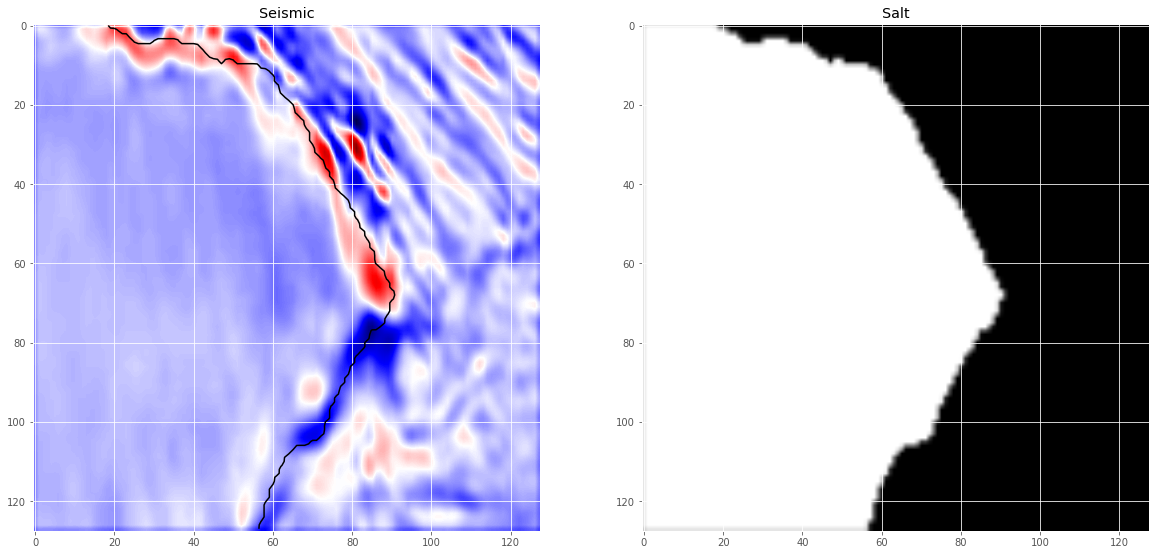

In [7]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

## 构建U-NET网络模型

In [8]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [9]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
       
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

In [11]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

#model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[my_iou_metric])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## 数据增强

In [12]:
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 2019
bs = 32

image_generator = image_datagen.flow(X_train, seed=seed, batch_size=bs, shuffle=True)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=bs, shuffle=True)

# Just zip the two generators to get a generator that provides augmented images and masks at the same time
train_generator = zip(image_generator, mask_generator)

## 训练U-NET网络模型

In [13]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [14]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/100
3400/3400 [==============================] - 12s 4ms/step - loss: 0.3767 - my_iou_metric: 0.3525 - val_loss: 1.2329 - val_my_iou_metric: 0.2268

Epoch 00001: val_loss improved from inf to 1.23287, saving model to model-tgs-salt.h5
Epoch 2/100
3400/3400 [==============================] - 8s 2ms/step - loss: 0.2867 - my_iou_metric: 0.5304 - val_loss: 0.8559 - val_my_iou_metric: 0.2425

Epoch 00002: val_loss improved from 1.23287 to 0.85589, saving model to model-tgs-salt.h5
Epoch 3/100
3400/3400 [==============================] - 8s 2ms/step - loss: 0.2709 - my_iou_metric: 0.5362 - val_loss: 0.2523 - val_my_iou_metric: 0.4518

Epoch 00003: val_loss improved from 0.85589 to 0.25233, saving model to model-tgs-salt.h5
Epoch 4/100
3400/3400 [==============================] - 8s 2ms/step - loss: 0.2411 - my_iou_metric: 0.5644 - val_loss: 0.3290 - val_my_iou_metric: 0.4138

Epoch 00004: val_loss did not improve from 0.25233
Epoch 5/100

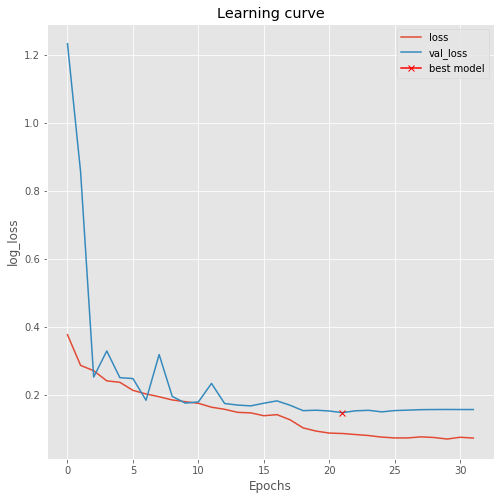

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## 加载训练好的网络模型

In [16]:
# Load best model
model.load_weights('model-tgs-salt.h5')

## 验证集性能评估

In [17]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

600/600 [==============================] - 0s 718us/step


[0.1476387510697047, 0.694]

## 网络预测

In [18]:
# Predict on train, and val 
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

600/600 [==============================] - 0s 590us/step


## TTA (Test Time Augmentation)

In [19]:
def show_flipped_images(x):
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(x[:,:,0], cmap='seismic')
    ax[0].set_title('original')
    ax[1].imshow(np.fliplr(x[:,:,0]), cmap='seismic')
    ax[2].imshow(np.flipud(x[:,:,0]), cmap='seismic')
    ax[3].imshow(np.fliplr(np.flipud(x[:,:,0])), cmap='seismic')

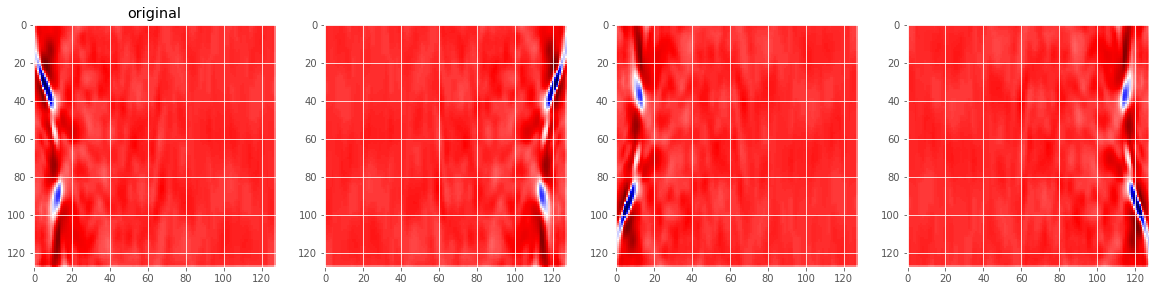

In [20]:
show_flipped_images(X_train[14])

In [21]:
class TTA_ModelWrapper():
    """A simple TTA wrapper for keras computer vision models.

    Args:
        model (keras model): A fitted keras model with a predict method.
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Wraps the predict method of the provided model.
        Augments the testdata with horizontal and vertical flips and
        averages the results.

        Args:
            X (numpy array of dim 4): The data to get predictions for.
        """

        pred = []
        for x_i in X:
            p0 = self.model.predict(self._expand(x_i[:, :, 0]))
            p1 = self.model.predict(self._expand(np.fliplr(x_i[:, :, 0])))
            p2 = self.model.predict(self._expand(np.flipud(x_i[:, :, 0])))
            p3 = self.model.predict(self._expand(np.fliplr(np.flipud(x_i[:, :, 0]))))
            p = (p0 +
                 self._expand(np.fliplr(p1[0][:, :, 0])) +
                 self._expand(np.flipud(p2[0][:, :, 0])) +
                 self._expand(np.fliplr(np.flipud(p3[0][:, :, 0])))
                 ) / 4
            pred.append(p)
        return np.array(pred)

    def _expand(self, x):
        return np.expand_dims(np.expand_dims(x, axis=0), axis=3)

In [22]:
tta_model = TTA_ModelWrapper(model)

## TTA模型预测

In [23]:
preds_val_tta = tta_model.predict(X_valid)
preds_train_tta = tta_model.predict(X_train)

In [24]:
def plot_sample(X, y, preds, preds_tta, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 5, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')

    ax[3].imshow(preds_tta[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted TTA')

    ax[4].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[4].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[4].set_title('Salt Predicted binary');

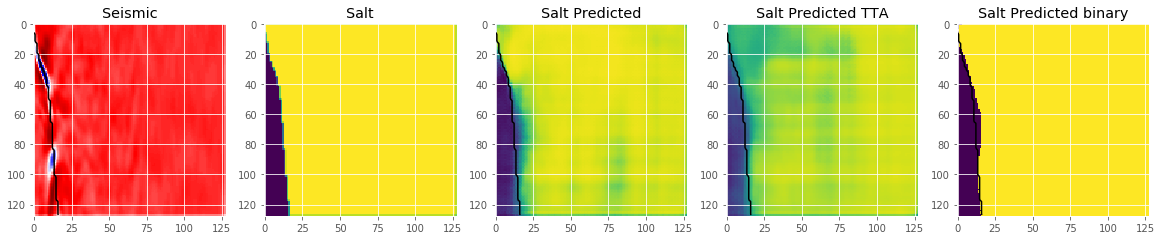

In [25]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_tta, preds_train_tta>0.5, ix=14)

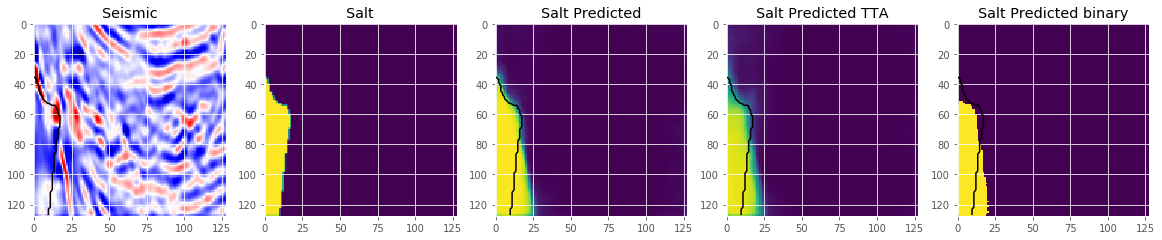

In [30]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_tta, preds_val_tta>0.5, ix=12)